In [2]:
import numpy as np

In [3]:
c1 = np.loadtxt("c1.txt")
c2 = np.loadtxt("c2.txt")

In [4]:
from numpy.random import shuffle
from scipy import stats
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

def bootstrap(split1, split2, metric, n_groups, n_iter, label1, label2):
    split_stats = []
    reject_H0_counter = 0
    for _ in tqdm(range(n_iter)):
        indices1 = np.random.choice(len(split1), len(split1), replace=True)
        indices2 = np.random.choice(len(split2), len(split2), replace=True)
        
        shuffled_split1 = split1[indices1, :]
        shuffled_split2 = split2[indices2, :]

        groups_split1 = np.split(shuffled_split1, n_groups)
        groups_split2 = np.split(shuffled_split2, n_groups)
             
        metric_result_split1 = metric(groups_split1)
        metric_result_split2 = metric(groups_split2)

        split_stats.append((np.mean(metric_result_split1), np.mean(metric_result_split2)))
        
        t, p_val = stats.ttest_ind(metric_result_split1, metric_result_split2, equal_var=False)
        if t > 1.96:
            reject_H0_counter += 1
    ACL = reject_H0_counter / n_iter
    split_stats = np.array(split_stats)

    plt.plot(split_stats[:, 0], label=label1)
    plt.plot(split_stats[:, 1], label=label2)
    plt.xlabel('bootrtrap iterations')
    plt.ylabel('metric value')
    plt.legend()
    plt.show()
    return ACL, split_stats

#### Проверим для метрики CTR следующие гипотезы:

- **H0**: различия в сплитах обусловлены случайностью

- **H1**: иначе

In [5]:
def ctr_metric(groups):
    all_groups_res = []
    session_size = len(groups[0])
    for i in range(len(groups)):
        noclicks_session_count = np.sum(~groups[i].any(axis=1))
        one_group_res = (session_size - noclicks_session_count) / session_size
        all_groups_res.append(one_group_res)
    return all_groups_res

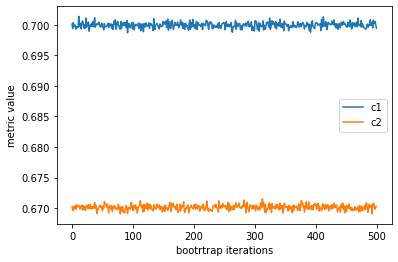

1.0

In [6]:
ACL_ctr, ctr_split_stats = bootstrap(c1, c2, ctr_metric, n_groups=1000, n_iter=500,
                                     label1='c1', label2='c2')
ACL_ctr

- Нулевая гипотеза отвергнута с уровнем значимости 0.05 на всех итерациях bootstrap. Т.е. различия в сплитах статистически значимы
- График иллюстрирует, что на первом сплите метрика больше, т.е. он "лучше"

#### Теперь проверим аналогичные гипотезы для метрики "количество отказов (доля сессий без кликов)":

In [7]:
def abandonment_rate_metric(groups):
    all_groups_res = []
    session_size = len(groups[0])
    for i in range(len(groups)):
        noclicks_session_count = np.sum(~groups[i].any(axis=1))
        one_group_res = noclicks_session_count / session_size
        all_groups_res.append(one_group_res)
    return all_groups_res

Т.к. это метрика "плохости", а по предыдущей метрике первый сплит оказался лучше, подадим в функцию сплиты в другом порядке: (split2, split1)

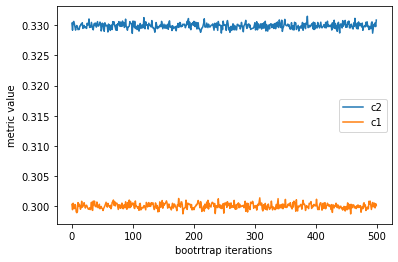

1.0

In [8]:
ACL_abandonment, abandonment_split_stats = bootstrap(c2, c1, abandonment_rate_metric, n_groups=1000, n_iter=500,
                                                     label1='c2', label2='c1')
ACL_abandonment

В данном случае нулевая гипотеза о том, что различия в сплитах случайны, также отвергнута на каждой итерации bootstrap. Первый сплит также оказался лучше ("отказов" в первом сплите меньше)